In [12]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
#Extracción de CSV de sitio de la onu
data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv', 
                   parse_dates=['Date_reported'])

In [3]:
#Trim de etiquetas de columna ... issue del CSV de origen.
dic={}
for col in data.columns.values.tolist():
    dic[col]=col.strip()
data.rename(columns=dic, inplace=True)
data = data[['Date_reported', 
             'Country_code', 
             'Country', 
             'New_cases', 
             'New_deaths']]

In [4]:
#Agrupar paises y definir la fecha del día uno
data_country = data[['Country','Country_code','Date_reported']].groupby(['Country','Country_code']).min()
data_country.reset_index(inplace=True)
data_country.rename(columns={'Date_reported':'Date_one'}, inplace=True)


In [5]:
#Crea calendario basico en base a las fechas minima y maxima de la data completa
cal_start = data['Date_reported'].min()
cal_end = data['Date_reported'].max()

l_date=[]
l_n=[]
l_country=[]
l_country_code=[]
l_n_ep=[]
for i in range(0, data_country.shape[0]):
    n=0
    d=cal_start
    while d < cal_end:
        d=cal_start + dt.timedelta(days=n)
        n+=1
        l_country.append(data_country['Country'].tolist()[i])
        l_country_code.append(data_country['Country_code'].tolist()[i])
        l_date.append(d)
        l_n.append(n)
        diff = d - data_country['Date_one'].tolist()[i]
        diff = diff.days+1
        if diff<1:
            diff=0
        l_n_ep.append(diff)
        
calendar=pd.DataFrame({'Country':l_country, 
                       'Country_code':l_country_code, 
                       'Date':l_date, 
                       'Pandemic_day':l_n, 
                       'Epidemic_day':l_n_ep})

In [6]:
data.drop('Country_code', axis=1, inplace=True)
data_final = calendar.merge(data, how='left', left_on=['Country','Date'], right_on=['Country','Date_reported'])
data_final.drop('Date_reported', axis=1, inplace=True)
data_final['New_deaths'].fillna(0,inplace=True)
data_final['New_cases'].fillna(0,inplace=True)

In [8]:
data_final.to_excel('Tabla.xlsx')

In [10]:
data_final

,Country,Country_code,Date,Pandemic_day,Epidemic_day,New_cases,New_deaths
0,Afghanistan,AF,2020-01-04,1,0,0.0,0.0
1,Afghanistan,AF,2020-01-05,2,0,0.0,0.0
2,Afghanistan,AF,2020-01-06,3,0,0.0,0.0
3,Afghanistan,AF,2020-01-07,4,0,0.0,0.0
4,Afghanistan,AF,2020-01-08,5,0,0.0,0.0
...,...,...,...,...,...,...,...
51595,"occupied Palestinian territory, including east...",PS,2020-08-26,236,175,585.0,0.0
51596,"occupied Palestinian territory, including east...",PS,2020-08-27,237,176,602.0,2.0
51597,"occupied Palestinian territory, including east...",PS,2020-08-28,238,177,622.0,6.0
51598,"occupied Palestinian territory, including east...",PS,2020-08-29,239,178,724.0,2.0


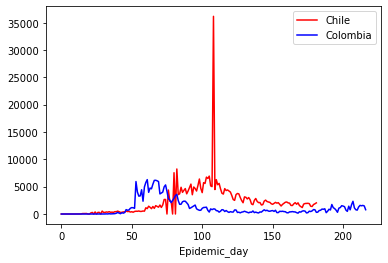

In [26]:
ax=plt.gca()
data_final[(data_final['Country']=='Chile')].plot(kind='line', label='Chile', x='Epidemic_day',y='New_cases',ax=ax, color='red')
data_final[(data_final['Country']=='Germany')].plot(kind='line', label='Colombia', x='Epidemic_day',y='New_cases',ax=ax, color='blue')
#data_final.plot(kind='line',x='Pandemic_day',y='num_pets', color='red', ax=ax)
plt.show()